# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# A. The business problem.
- Starbucks collects data on offers and purchase transactions
- Will this data inform purchase transactions? Can we predict the transaction of a customer based on their demographic data?
- The expectation is that a classifier model will explore in the interaction in the app is able to be connected to the demographic data.
    - We will explore this success with the Accuracy, Precision, and F-1 score, as well as a confusion matrix with the withheld test dataset.
    - An F-1 score is great for classification because it allows us to evaluate precision and recall in one value. A better F-1 score means a more well performing model. 
- The regression model will determine if demographic data can predict the transaction amount.
    - For regression we can explore the R-squared score and residuals. This shows how much of the amount of the transaction isn't captured by the model for the test data.

In [29]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
clf = RandomForestClassifier()

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Part 1: Descriptive Statistics & Data Exploration
Review the data available and explore the user details. Look at value counts of important features and consider the missing variables present.

In [30]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [31]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [32]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [33]:
profile.describe() # descriptive statistics of user profile data

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Text(0.5, 0, 'Age')

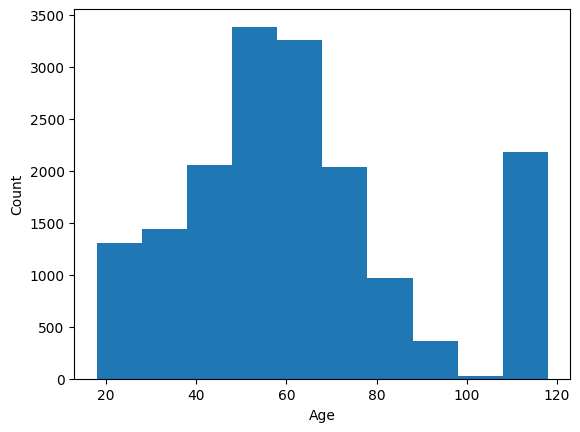

In [34]:
plt.hist(profile.age)
plt.ylabel('Count')
plt.xlabel('Age')

Text(0.5, 0, 'Income')

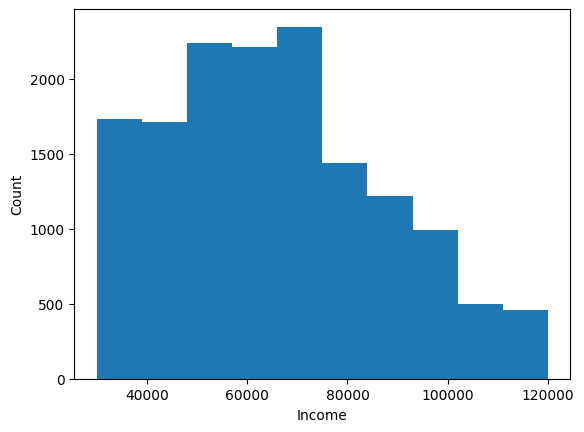

In [35]:
plt.hist(profile.income)
plt.ylabel('Count')
plt.xlabel('Income')

In [36]:
profile.isna().sum() # determine the missing values, looks like a potential overlap between gender and income

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [37]:
portfolio.offer_type.value_counts()# explore portfolio a bit more

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

In [38]:
clean_profile = profile.dropna() # cleaned profile data
clean_profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

# 2. Data Modification for Creating Useful Predictions
Combine the profile data with the transcript data so that we can examine user interactions.

In [39]:
transcript['id'] = transcript['person']
transcript.drop(columns = ['person'], inplace = True)
profile_interactions = clean_profile.merge(transcript, on = 'id')

In [40]:
bio_sex = pd.get_dummies(profile_interactions.gender, drop_first = True)
profile_interactions = profile_interactions.join( bio_sex, sort = False)
profile_interactions.drop(columns = ['gender'], inplace = True)

In [41]:
profile_interactions.head()

,age,id,became_member_on,income,event,value,time,M,O
0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,False,False
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,False,False
2,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,False,False
3,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,False,False
4,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,False,False


In [42]:
profile_interactions.event.value_counts()

event
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: count, dtype: int64

Text(0, 0.5, 'Amount ($) In Transaction')

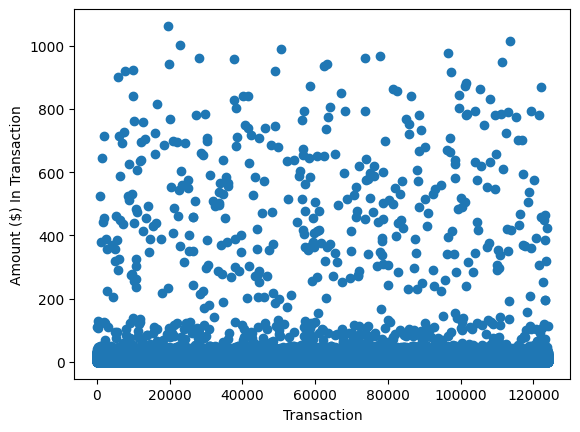

In [43]:
spend_transactions = profile_interactions[profile_interactions.event == 'transaction']
spend_transactions = spend_transactions.join(spend_transactions['value'].apply(pd.Series))
spend_transactions['amount'] = spend_transactions['amount'].astype('float')
plt.scatter(range(len(spend_transactions['amount'])), spend_transactions['amount'])
plt.xlabel('Transaction')
plt.ylabel('Amount ($) In Transaction')

**We see that most transactions are under $100. This may affect the training of the model, but we do have quite a few several hundred dollar transactions.** 

In [44]:
# Create train test split data
y = profile_interactions.event
X = profile_interactions.drop(columns = ['value','event','id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 3. Create a model that predicts interaction type based on personal data

In [45]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [46]:
# evaluate model
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

offer completed       0.07      0.06      0.07      6453
 offer received       0.69      0.73      0.71     13400
   offer viewed       0.19      0.13      0.15     10001
    transaction       0.57      0.64      0.61     24699

       accuracy                           0.50     54553
      macro avg       0.38      0.39      0.38     54553
   weighted avg       0.47      0.50      0.48     54553



### The model performs poorly. The offer a member recieves is not easily predicted based on their demographic information. Lets look at the confusion matrix.

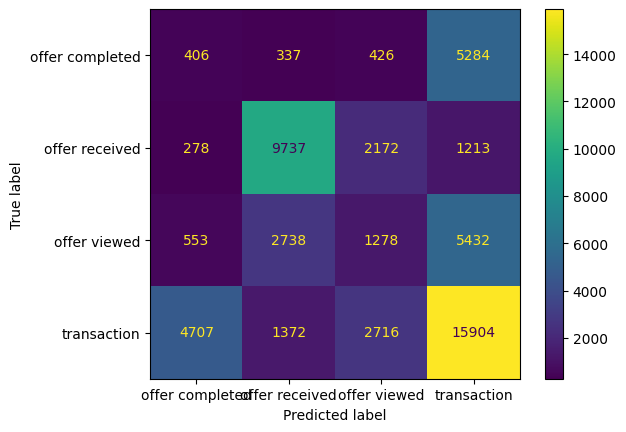

In [47]:
labels = ['offer completed','offer received', 'offer viewed', 'transaction']
confusion_matrix(y_test, y_pred, labels = labels)
_ = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

# 3.a. Lets evaluate if grid searching parameters can lead us to a more robust model.

In [51]:
scorer = make_scorer(f1_score, average = 'weighted')
parameters = {
            'n_estimators': [150, 250]
            , 'min_samples_split': [5, 10]
        }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=666)
grid = GridSearchCV(clf, param_grid = parameters, scoring = scorer)
# fit the model
grid.fit(X_train, y_train)

# get the best model
final_model = grid.best_estimator_
# evaluate model
y_pred = final_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

c:\Users\enders\.conda\envs\capstone\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\enders\.conda\envs\capstone\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\enders\.conda\envs\capstone\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\enders\.conda\envs\capstone\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\enders\.conda\envs\capstone\

                 precision    recall  f1-score   support

offer completed       0.05      0.03      0.04      6453
 offer received       0.73      0.81      0.77     13400
   offer viewed       0.26      0.14      0.18     10001
    transaction       0.59      0.73      0.65     24699

       accuracy                           0.56     54553
      macro avg       0.41      0.43      0.41     54553
   weighted avg       0.50      0.56      0.52     54553



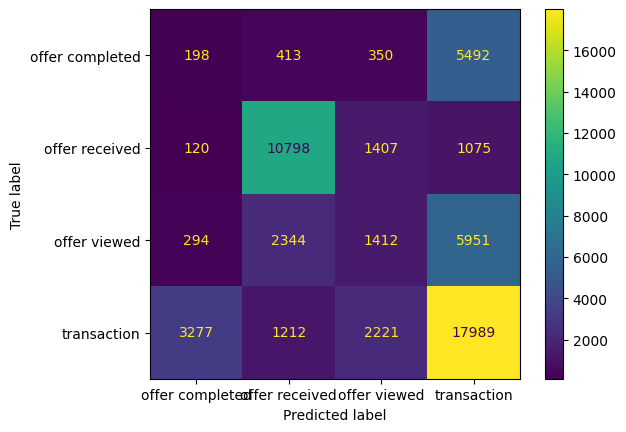

In [52]:
labels = ['offer completed','offer received', 'offer viewed', 'transaction']
confusion_matrix(y_test, y_pred, labels = labels)
_ = ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)

**We're able to see our model improve with grid searching, but this is not a relaiable model. It's likely that future exploration is necessary to answer this question. Our best model has a final F-1 score of 0.52.**

# 4. Instead of predicting labels, can we instead understand the purchase interactions, i.e. predict how much someone spends?

In [53]:
# Create train test split data
y = spend_transactions.amount
X = spend_transactions.drop(columns = ['value','event','id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor().fit(X_train, y_train)

In [55]:
y_pred = reg.predict(X_test)
diffs = y_test - y_pred
print('R-squared of test data: ', reg.score(X_test, y_test))

R-squared of test data:  0.9999797630054561


**This model already works so well, so we will move forward with it without grid searching.**

Text(0.5, 0, 'Transaction')

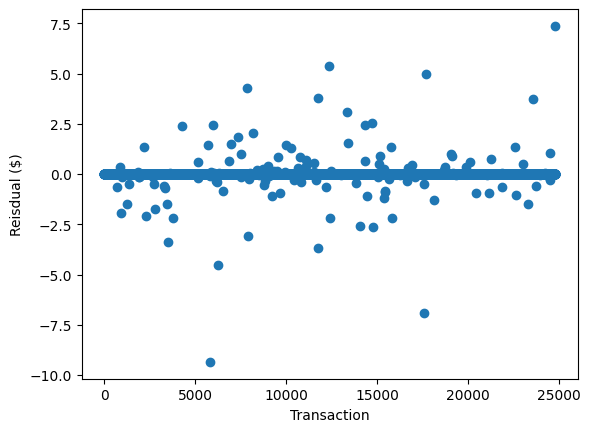

In [56]:
plt.scatter(range(len(diffs)), diffs)
plt.ylabel('Reisdual ($)')
plt.xlabel('Transaction')

**We can readily predict the user's spending withing +/- $10s.**

# 5. Results
The regression model performs better than the classification model in terms of overall predictive accuracy. While we can't judge them directly, we can see by the confusion matrix in comparison to the residuals, we have a much easier time predicting the amount of a transaction compared to the interaction received with the app. 

A few reasons in particular lead to the conclusion that demographics can't inform the offer a Starbucks Rewards Member should recieve.
- App interactions are not currently sent based on informed details of the member
- A customer can already have decided to complete a transaction, even if they didn't open the app to use a reward
- A customer can view a reward but never use the promotion

Transactions are likely better to be predicted by demographic informaiton because people's spending patterns can be linked to the demographic information more easily in this case. We could actually use this to predict if we should send a user a promotion; if a user is always going to make a transaction regardless of their promotion, we shouldn't send them a promotion because capitalism.